# **1) Libraries**

In [4]:
import os
import cv2
import torch
import  detection
import torchvision
import numpy as np
from PIL import Image
from tqdm import tqdm
from pprint import pprint
import albumentations as A
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from torchmetrics.detection import MeanAveragePrecision
from albumentations.pytorch.transforms import ToTensorV2

ModuleNotFoundError: No module named 'detection'

# **2) Prepare Dataset**

Extracting Images and Annotations training and Testeing addresses

In [19]:
## Directory address where Images and Annotation folders (they must be in seperate folders) have been located
data_root = "/home/moh7596/Dataset/VOCtrainval_11-May-2012/VOCdevkit/VOC2012"

## "JPEGImages" is our Images folder name
images_dir = os.path.join(data_root, "JPEGImages")
image_files = sorted(os.listdir(images_dir))

## "JPEGImages" is our Annortation folder name
annotations_dir = os.path.join(data_root, "Annotations")
annotation_files = sorted(os.listdir(annotations_dir))

## Splittig data into training and testing (split rate is 0.8/0.2)
train_image_files, val_image_files, train_annotation_files, val_annotation_files = train_test_split(
    image_files, annotation_files, test_size=0.2, random_state=42)

## training and testing full address
train_img_path = [os.path.join(images_dir, img) for img in train_image_files]
train_ann_path = [os.path.join(annotations_dir, ann) for ann in train_annotation_files]
test_img_path = [os.path.join(images_dir, img) for img in val_image_files]
test_ann_path = [os.path.join(annotations_dir, ann) for ann in val_annotation_files]

## labels name
classes = ["background"]
for adr in train_ann_path:
    tree = ET.parse(adr)
    root = tree.getroot()
    for obj in root.findall('object'):
        name = obj.find('name').text
        if(name not in classes):
            classes.append(name)

## labels and their corresponding index
labels = {}
for i, label in enumerate(classes):
    labels[label] = i


print(classes)
print(labels)

print("."*180)
print(f"The total number of training samples: {len(train_img_path)}")
print(f"The total number of testing samples: {len(test_img_path)}")

['background', 'person', 'dog', 'car', 'train', 'aeroplane', 'sheep', 'chair', 'horse', 'diningtable', 'tvmonitor', 'bird', 'pottedplant', 'motorbike', 'boat', 'sofa', 'bottle', 'cat', 'bicycle', 'bus', 'cow']
{'background': 0, 'person': 1, 'dog': 2, 'car': 3, 'train': 4, 'aeroplane': 5, 'sheep': 6, 'chair': 7, 'horse': 8, 'diningtable': 9, 'tvmonitor': 10, 'bird': 11, 'pottedplant': 12, 'motorbike': 13, 'boat': 14, 'sofa': 15, 'bottle': 16, 'cat': 17, 'bicycle': 18, 'bus': 19, 'cow': 20}
....................................................................................................................................................................................
The total number of training samples: 13700
The total number of testing samples: 3425


In [24]:
def collate_fn(batch):
    return tuple(zip(*batch))

    

class VOCImagesDataset(torch.utils.data.Dataset):
    def __init__(self, classes, images_adr, annotations_adr, width, height, transforms=None):
        """DataLoader

        PARAMETERS:
        =================================================================
        transforms ---> Transformation you want to apply on images

        images_adr ---> a list of images address

        annotations_adr ---> a list of annotations adress

        height ---> h of the desired resized image

        width ---> w of the desired resized image

        classes ---> a list of labels name (21: 20 labels + 1 back ground)
        """
        self.transforms = transforms
        self.images_adr = images_adr
        self.annotations_adr = annotations_adr
        self.height = height
        self.width = width
        self.classes = classes


    def __len__(self):
        return len(self.images_adr)
    

    def __getitem__(self, idx):
        """DataLoader

        INPUTS:
        =================================================================
        idx ---> Index of a data you want to read

        RETURNS:
        =================================================================
        img_res ---> A list of tensors with the size of (3, self.height, self.width). The list length is equal ot the Batch size

        target ---> A tupple of length Batch_Size tha has the following keys:
                    boxes: A tensor of size (n_bbox, 4)
                    labels: A tensor the existing classes in that image
                    area: A tensor of the areas of the bounding boxes
        """

        # reading the images and converting them to correct size and color 
        image_path = self.images_adr[idx]
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0
        
        # annotation file
        annot_file_path = self.annotations_adr[idx]
        
        boxes = []
        labels = []
        tree = ET.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # labels and box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes[member.find('name').text])
            
            # bounding box
            xmin = int(float(member.find('bndbox').find('xmin').text))
            xmax = int(float(member.find('bndbox').find('xmax').text))
            
            ymin = int(float(member.find('bndbox').find('ymin').text))
            ymax = int(float(member.find('bndbox').find('ymax').text))
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = torch.as_tensor((boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]), dtype=torch.float32)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        # convert labels into a torch.Tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            img_res = self.transforms(img_res)
            
        return img_res, target

    



transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# use our dataset and defined transformations
train_dataset = VOCImagesDataset(labels, train_img_path, train_ann_path, 480, 480, transforms= transform)
test_dataset  = VOCImagesDataset(labels, test_img_path, test_ann_path, 480, 480, transforms= transform)

# define training and validation data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)


out = next(iter(train_loader))
"""print(out[0][0].shape)
print(len(out))
print(out[1])
print(len(out[1]))
print(out[1][0])
print(out[1][0]['boxes'])"""

"print(out[0][0].shape)\nprint(len(out))\nprint(out[1])\nprint(len(out[1]))\nprint(out[1][0])\nprint(out[1][0]['boxes'])"

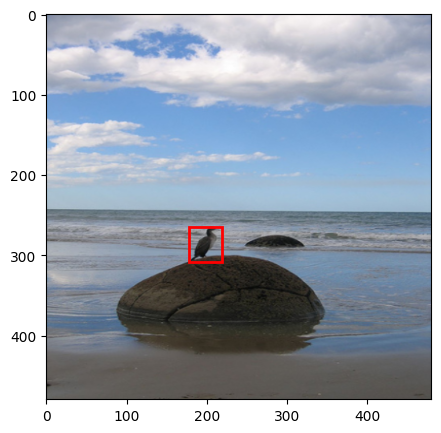

In [25]:
def plot_img_bbox(img, target):
    """ Function to visualize bounding boxes in the image

        INPUTS:
        =================================================================
        img ---> A tensor of size (h, w, 3)

        target ---> targets in order ot get the bbox of the corresponding image
    """
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    ax.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Drawing the bounding box on top of the image
        ax.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes
img, target = train_dataset[300]
img = img.permute(1,2,0)
plot_img_bbox(img, target)

# **3) Model Architecture**

In [5]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

num_classes = len(classes)  # 20 class (VOC) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

/home/moh7596/anaconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/moh7596/anaconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/moh7596/anaconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  warnings.warn(
/home/moh7596/anaconda3/envs/my_env/lib/python3.9/site-pac

# **4) Parameters**

In [21]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

Non_Max_Suppression_th = 0.75
num_epochs = 1

# **5) Training**

In [8]:
##Return the average loss 
class Averager:      
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

        

model.train()
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets in tqdm(train_loader):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)   ##Return the loss

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)  #Average out the loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()


        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

100%|██████████| 3425/3425 [25:39<00:00,  2.23it/s]

Epoch #0 loss: 0.3282754383165471


In [20]:
import gc
gc.collect()
torch.cuda.empty_cache()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34006ea9d0>
Traceback (most recent call last):
  File "/home/moh7596/anaconda3/envs/my_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/home/moh7596/anaconda3/envs/my_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1445, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/moh7596/anaconda3/envs/my_env/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/moh7596/anaconda3/envs/my_env/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/moh7596/anaconda3/envs/my_env/lib/python3.9/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/moh7596/anaconda3/envs/my_env/lib/python3.9/selectors.py", line 416, in select
 

# **6) Evaluation**

Some Metrics (IoU and mAP)

In [9]:
def IoU(pred_bbox, true_bbox):
    """ Function to Compute the IoU

        INPUTS:
        =================================================================
        pred_bbox ---> A tensor of size (P, 4) in which P stands for the total predicted number of bboxes in the image

        true_bbox ---> A tensor of size (Q, 4) in which Q stands for the total number of ground truth bboxes in the image
        
        RETURNS:
        =================================================================
        iou_matrix ---> A matrix of size (P, Q) tha computes the IoU between each pred_bbox and true_bbox
    """
    iou_matrix = np.zeros((pred_bbox.shape[0], true_bbox.shape[0]))

    for i in range (pred_bbox.shape[0]):
        for j in range(true_bbox.shape[0]):
            ix1 = np.maximum(pred_bbox[i][0], true_bbox[j][0])
            iy1 = np.maximum(pred_bbox[i][1], true_bbox[j][1])
            ix2 = np.minimum(pred_bbox[i][2], true_bbox[j][2])
            iy2 = np.minimum(pred_bbox[i][3], true_bbox[j][3])
     
            # Intersection height and width.
            i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
            i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))
            
            area_of_intersection = i_height * i_width
            
            # Ground Truth dimensions.
            gt_height = true_bbox[j][3] - pred_bbox[i][1] + 1
            gt_width = true_bbox[j][2] - pred_bbox[i][0] + 1
            
            # Prediction dimensions.
            pd_height = pred_bbox[j][3] - pred_bbox[i][1] + 1
            pd_width = pred_bbox[j][2] - pred_bbox[i][0] + 1
            
            area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
     
            iou = area_of_intersection / area_of_union
            iou_matrix[i,j] = iou
    return iou_matrix

In [10]:
def bbox_display(image, pred_box, true_box, scores, label):
    """ Function which is used in drawing Bounding box and Ground Truth

        INPUTS:
        =================================================================
        image ---> A tensor of size (h, w, 3)

        pred_bbox ---> A tensor of size (P, 4) in which P stands for the total predicted number of bboxes in the image

        true_bbox ---> A tensor of size (Q, 4) in which Q stands for the total number of ground truth bboxes in the image

        scores ---> The corresponding score of each predicted bbox

        label ---> The predicted label of each bbox
    """
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    ax.imshow(image)
    
    ## Drawing the true bboxes in green
    for box in true_box:
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                width, height,
                                linewidth = 2,
                                edgecolor = 'g',
                                facecolor = 'none')
        ax.add_patch(rect)

    ## Drawing the predicted bboxes in red
    for box, score, label in zip(pred_box, scores, labels ):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                width, height,
                                linewidth = 2,
                                edgecolor = 'r',
                                facecolor = 'none')
        ax.add_patch(rect)
        
        ## displaying the corresponding score and label of each bbox
        plt.text(x, y, f'{classes[label]}: {score:.2f}', color='r', fontsize=10, weight='bold')
    plt.show()

{'classes': tensor([ 1, 12], dtype=torch.int32),
 'map': tensor(0.5500),
 'map_50': tensor(1.),
 'map_75': tensor(0.5000),
 'map_large': tensor(0.5000),
 'map_medium': tensor(-1.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.6000),
 'mar_1': tensor(0.5500),
 'mar_10': tensor(0.5500),
 'mar_100': tensor(0.5500),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.5000),
 'mar_medium': tensor(-1.),
 'mar_small': tensor(0.6000)}


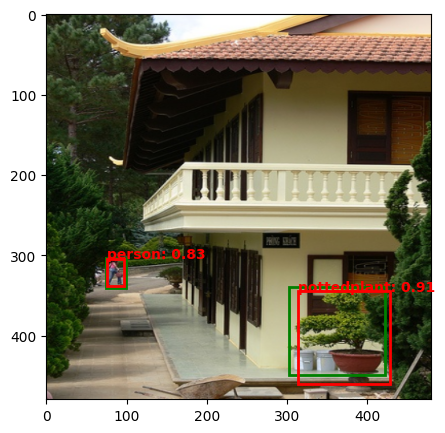

In [26]:



results=[]
model.eval()
images, targets = test_dataset[501]
images = [images]
targets = [targets]
images = list(image.to(device) for image in images)

sample = images[0].permute(1,2,0).cpu().numpy()

outputs = model(images)

boxes = outputs[0]['boxes'].data.cpu().numpy()
scores = outputs[0]['scores'].data.cpu().numpy()
labels = outputs[0]['labels'].data.cpu().numpy()

labels = labels[scores > Non_Max_Suppression_th]
boxes = boxes[scores > Non_Max_Suppression_th].astype(np.int32)
scores = scores[scores > Non_Max_Suppression_th]

iou = IoU(boxes, targets[0]['boxes'].data.cpu().numpy())


iou = iou[iou > 0.5]

preds = [dict(
    boxes=torch.tensor(boxes),
    scores=torch.tensor(scores),
    labels=torch.tensor(labels))]
targs = [dict(
    boxes=torch.tensor(targets[0]['boxes'].data.cpu().numpy()),
    labels=torch.tensor(targets[0]['labels'].data.cpu().numpy())
)]

metric = MeanAveragePrecision(iou_type="bbox")
metric.update(preds, targs)
pprint(metric.compute())

bbox_display(sample, boxes, targets[0]['boxes'].data.cpu().numpy(), scores, labels)




In [17]:
def Evaluation_Metrics(model, non_max_suppression_th):
    all_IoUs = []
    all_mAPs = []
    metric = MeanAveragePrecision(iou_type="bbox")
    model.eval()
    for image, target in tqdm(test_dataset):
        images = image.to(device)
        smaple = images.permute(1,2,0).cpu().numpy()
        
        outputs = model([images])
        pred_boxes = outputs[0]['boxes'].data.cpu().numpy()
        pred_scores = outputs[0]['scores'].data.cpu().numpy()
        pred_labels = outputs[0]['labels'].data.cpu().numpy()

        pred_labels = pred_labels[pred_scores > non_max_suppression_th]
        pred_boxes = pred_boxes[pred_scores > non_max_suppression_th].astype(np.int32)
        pred_scores = pred_scores[pred_scores > non_max_suppression_th]
        
        iou = IoU(boxes, targets[0]['boxes'].data.cpu().numpy())
        all_IoUs.extend(list(iou[iou > 0.5]))

        preds = [dict(
            boxes=torch.tensor(pred_boxes),
            scores=torch.tensor(pred_scores),
            labels=torch.tensor(pred_labels))]
        targs = [dict(
            boxes=torch.tensor(targets[0]['boxes'].data.cpu().numpy()),
            labels=torch.tensor(targets[0]['labels'].data.cpu().numpy()))]
        
        metric.update(preds, targs)
        all_mAPs.append(metric.compute()['map'].data.cpu().numpy())
    print("."*100)
    print(f"Testing Set IoU: {np.mean(all_IoUs)}.")
    print(f"Testing Set mAP: {np.mean(all_mAPs)}.")
    print("."*100)

Evaluation_Metrics(model, Non_Max_Suppression_th)

100%|██████████| 3425/3425 [1:01:13<00:00,  1.07s/it]

....................................................................................................
Testing Set IoU: 0.8603141735129746.
Testing Set mAP: 0.00019240760593675077.
....................................................................................................
